# Batina Advanced Weight Recovery

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.


In [1]:
import pathlib
TEST_RESULT_DIR = './results'

pathlib.Path(TEST_RESULT_DIR).mkdir(parents=True, exist_ok=True) 

In [2]:
import sys
sys.path.append("../")

from pybatina.advanced_weight_recovery import *
from pybatina.utils import *

In [3]:
import numpy as np

guess_range=(-5.0, 5.0)
# the number of guess values in the guess range
secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = 3.9994454383850098
secret_number = int_to_float(float_to_int(secret_number))

print('secret_number =', secret_number)

secret_number = 3.9994454383850098


In [4]:
number_of_best_candidates = 15
awr = AdvancedWeightRecovery(guess_range=guess_range, number_of_best_candidates=number_of_best_candidates)

## ONE STEP

In [5]:
secret_hamming_weight_set = [np.vectorize(hamming_weight)(input_values * secret_number) for input_values in awr.input_value_set]    
s = awr.recover_weight(secret_hamming_weight_set)
s.iloc[:awr.number_of_best_candidates]

<ipython-input-5-9a5bf5d30195>:1: RuntimeWarning: overflow encountered in multiply
  secret_hamming_weight_set = [np.vectorize(hamming_weight)(input_values * secret_number) for input_values in awr.input_value_set]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


3.999866    1.000000
3.999444    1.000000
3.999445    1.000000
3.999722    1.000000
3.999934    0.999594
3.999442    0.999594
3.999446    0.999594
3.999721    0.999594
3.999723    0.999594
3.999723    0.999594
3.999861    0.999594
3.999446    0.999594
3.999452    0.999533
3.999445    0.999533
3.999935    0.998484
dtype: float64

## STEP-BY-STEP

### Correlation of mantissa

In [6]:
%%time

numbers = None
mantissa_correlations = {}
for mantissa_byte_index in range(len(AdvancedWeightRecovery.MANTISSA_THREE_BYTES)):
    guess_numbers = awr.build_guess_values(component='mantissa', mantissa_byte_index=mantissa_byte_index, numbers=numbers)
    known_inputs = awr.build_input_values(component='mantissa', mantissa_byte_index=mantissa_byte_index)
    secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number).astype(np.float32)
    mantissa_corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False)
    mantissa_correlations[mantissa_byte_index] = mantissa_corr
    numbers = mantissa_corr.index[:awr.number_of_best_candidates]

CPU times: user 15.4 s, sys: 324 ms, total: 15.7 s
Wall time: 15.7 s


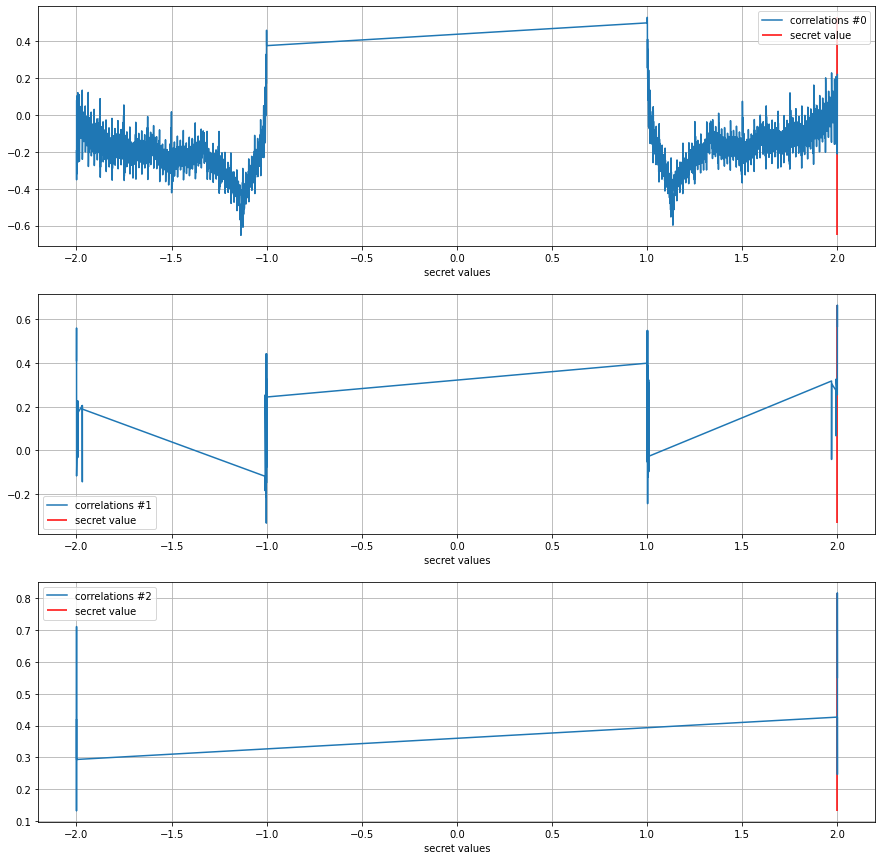

In [7]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=len(mantissa_correlations), ncols=1, figsize=(15, 5 * len(mantissa_correlations)))
for idx in range(len(mantissa_correlations)):
    corr = mantissa_correlations[idx].sort_index()
    corr.plot(ax=ax[idx], label='correlations #%d' % idx)
    x = int_to_float((float_to_int(secret_number) & ~(0xff<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS)) | (127<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS))
    ax[idx].vlines(x, corr.min(), corr.max(), color='red', label='secret value')
    ax[idx].legend()
    ax[idx].grid(True)
    ax[idx].set_xlabel('secret values')

In [8]:
numbers=mantissa_corr.index[:awr.number_of_best_candidates]
numbers

Float64Index([1.9997227191925049,  1.999723196029663, 1.9998613595962524,
               1.999861240386963, 1.9997224807739258, 1.9998605251312256,
              1.9997211694717407, 1.9999668598175049, 1.9997230768203735,
               1.999861478805542, 1.9997261762619019, 1.9999306201934814,
              1.9999327659606934, 1.9997221231460571,  1.999967336654663],
             dtype='float64')

### Correlation exponent

In [9]:
%%time
known_inputs = awr.build_input_values(component='exponent')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
guess_numbers = awr.build_guess_values(component='exponent', numbers=numbers)
guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= guess_range[0], guess_numbers <= guess_range[1]))]
mantisa_exp_corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False)

<timed exec>:2: RuntimeWarning: overflow encountered in multiply
<timed exec>:4: RuntimeWarning: invalid value encountered in greater_equal
<timed exec>:4: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 1.04 s, sys: 35.8 ms, total: 1.07 s
Wall time: 1.1 s


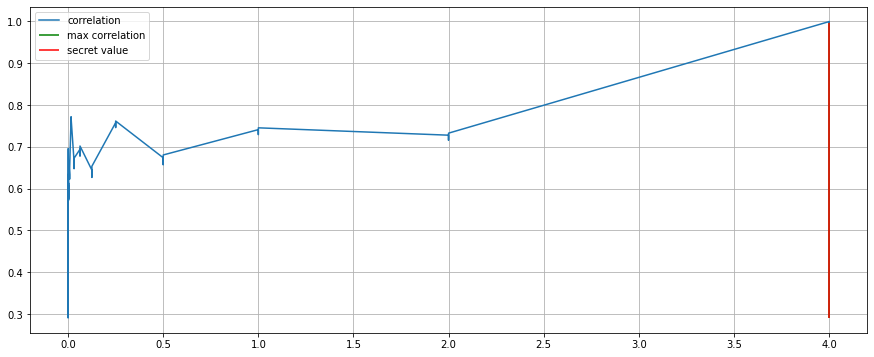

In [10]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6), label='correlation')
ax.vlines(mantisa_exp_corr.idxmax(), mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [11]:
print('secret_number:', secret_number)
mantisa_exp_corr.iloc[:number_of_best_candidates]

secret_number: 3.9994454383850098


3.999866    1.000000
3.999722    1.000000
3.999445    1.000000
3.999444    1.000000
3.999446    0.999594
3.999442    0.999594
3.999861    0.999594
3.999723    0.999594
3.999723    0.999594
3.999721    0.999594
3.999446    0.999594
3.999934    0.999594
3.999452    0.999533
3.999445    0.999533
3.999935    0.998484
dtype: float64